In [392]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
import pandas as pd
from tqdm import tqdm
from collections import defaultdict
from abc import ABC, abstractmethod

np.random.seed(33)

In [393]:
# Create abstract class for distributions
class Distribution(ABC):
    @abstractmethod
    def pdf(self, x):
        pass
    
    @abstractmethod
    def sample(self, n):
        pass

# Create class for latent distribution
class LatentDistribution(Distribution):
    alpha: np.ndarray   # 1d array holding alpha hyperparams a_{k}
    beta: float         # beta hyperparam
    n_mat: np.ndarray   # 3d array holding n_{k,d,w}
    K: int              # number of topics

    def __init__(self, K, n_mat, alpha=None, beta=1e-3):
        self.K = K
        self.beta = beta
        self.n_mat = n_mat

        assert n_mat.ndim == 3
        assert n_mat.shape[0] == K

        self.alpha = np.ones(K, dtype=float) if alpha is None else alpha

    def get_gamma(self, k, d, w):
        alpha_dw = self.alpha[k]
        n_dk = self.n_mat[k,d,:].sum() - self.n_mat[k,d,w]
        n_wk = self.n_mat[k,:,w].sum() - self.n_mat[k,d,w]

        V = self.n_mat.shape[2]
        n_k = self.n_mat[k,:,:].sum() - self.n_mat[k,d,w]
        
        return (alpha_dw + n_dk)*(self.beta + n_wk)/(self.beta*V + n_k)
    
    def pmf(self, d, w):
        g_k = np.array([self.get_gamma(k,d,w) for k in range(self.K)])
        return g_k/g_k.sum()
        
    def pdf(self, k, d, w): 
        return self.pmf(d,w)[k]

    def sample(self, d, w):
        pmf = self.pmf(d,w)
        return np.random.multinomial(1, pmf).argmax()
    
    def update_n(self, k, d, w):
        self.n_mat[k,d,w] += 1

    def get_phi(self, k, w):
        V = self.n_mat.shape[2]
        n_k = self.n_mat[k,:,:].sum()
        return (self.beta + self.n_mat[k,:,w].sum())/(self.beta*V + n_k)
    
    def get_theta(self, k, d):
        n_d = self.n_mat[:,d,:].sum()
        return (self.alpha[k] + self.n_mat[k,d,:].sum())/(self.alpha.sum() + n_d)

In [394]:
# Implement LDA with collapsed Gibbs sampling
class LDA():
    k: int                              # number of topics
    d: int                              # number of documents
    w: int                              # number of words in vocabulary
    vocab: defaultdict                  # vocabulary mapping words to indices
    r_vocab: defaultdict                # reverse vocabulary mapping indices to words
    docs: np.ndarray                    # 2d list holding documents with raw words
    n_iter: int                         # number of iterations
    latent_dist: LatentDistribution     # latent distribution Z

    def __init__(self, k, docs, n_iter=100, alpha=None, beta=1e-3):
        self.k = k
        self.d = len(docs)
        self.docs = docs
        self.vocab = self.setup_vocab(docs)
        self.r_vocab = dict(map(reversed, self.vocab.items()))
        self.w = len(self.vocab)
        self.n_iter = n_iter

        self.n_mat = np.zeros((self.k,self.d,self.w), dtype=int)
        self.latent_dist = LatentDistribution(k, self.n_mat, alpha, beta)

    def setup_vocab(self, docs):
        vocab = defaultdict(int)
        for doc in docs:
            for word in doc:
                if word not in vocab:
                    vocab[word] = len(vocab)
        return vocab

    def fit(self):
        for _ in tqdm(range(self.n_iter)):
            for d in range(self.d):
                for n in range(len(self.docs[d])):
                    w = self.vocab[self.docs[d][n]]
                    k = self.latent_dist.sample(d,w)
                    self.latent_dist.update_n(k,d,w)

    def get_phi(self):
        phi = np.zeros((self.k,self.w))
        for k in range(self.k):
            for w in range(self.w):
                phi[k,w] = self.latent_dist.get_phi(k,w)
        return phi
    
    def get_theta(self):
        theta = np.zeros((self.k,self.d))
        for k in range(self.k):
            for d in range(self.d):
                theta[k,d] = self.latent_dist.get_theta(k,d)
        return theta
    
    @staticmethod
    def plot_top_words(phi, r_vocab, codes, n=10):
        # plot heatmap of top words with seaborn
        cols = [f'Topic {i}' for i in range(phi.shape[0])]
        idx = [r_vocab[i] for i in range(phi.shape[1])]
        idx = [f"{i}-{codes.loc[i]['SHORT_TITLE']}" if i in codes.index else 'no desc' for i in idx]
        df = pd.DataFrame(phi.T, index=idx, columns=cols)

        rows = []
        for col in df.columns:
            df = df.sort_values(by=col, ascending=False)
            rows.append(df.head(n))

        topk = pd.concat(rows, axis=0)

        fig, ax = plt.subplots(figsize=(5, 12))
        sns.heatmap(topk, cmap='rocket_r', square=True, yticklabels=True, 
                    ax=ax, linewidths=.5, cbar_kws=dict(shrink=0.2, label="topic prob"))
        
        ax.set_title(f'Top {n} words per topic')
        for tick in ax.get_xticklabels():
            tick.set_rotation(90)

    @staticmethod
    def plot_topic_word_r(theta, docs, words=[331,332,340]):
        v = []
        for w in words:
            mask_w = np.array([str(w) in str(doc) for doc in docs], dtype=int)
            r = [np.corrcoef(theta_k, mask_w)[0,1] for theta_k in theta]
            v.append(r)

        v = np.array(v)
        idx = [f'Topic {i}' for i in range(theta.shape[0])]
        df = pd.DataFrame(v.T, index=idx, columns=[f"icd-{w}" for w in words])
        
        fig, ax = plt.subplots(figsize=(5, 5))
        sns.heatmap(df, cmap='vlag', yticklabels=True, ax=ax, 
                    linewidths=.5, cbar_kws=dict(shrink=0.2, label="word-topic corr"))

        ax.set_title(f'Topic correlation with selected words')
    

    @staticmethod
    def plot_top_docs(theta, docs, n=100, words=[331,332,340]):
        # plot heatmap of top documents with seaborn
        cols = [f'Topic {i}' for i in range(theta.shape[0])]
        wcols = [f"icd-{w}" for w in words]
        cmap = colors.ListedColormap(['white', 'red', 'blue', 'green'])
        idx = []

        for i, w in enumerate(words):
            mask_w = np.array([i+1 if str(w) in str(doc) else 0 for doc in docs], dtype=int)
            idx.append(mask_w)

        idx = np.array(idx)

        df1 = pd.DataFrame(idx.T, columns=wcols)
        df2 = pd.DataFrame(theta.T, columns=cols)
        df = df1.join(df2)

        rows1 = []
        rows2 = []
        for col in cols:
            df = df.sort_values(by=col, ascending=False)
            rows1.append(df.head(n)[wcols])
            rows2.append(df.head(n)[cols])

        topk1 = pd.concat(rows1, axis=0)
        topk2 = pd.concat(rows2, axis=0)

        fig, (ax1, ax2) = plt.subplots(1, 2, width_ratios=[1,5], figsize=(6, 10))
        sns.heatmap(topk1, cmap=cmap, cbar=False, yticklabels=False, ax=ax1)
        sns.heatmap(topk2, cmap='rocket_r', cbar=True, yticklabels=False, 
                    ax=ax2, cbar_kws=dict(shrink=0.2, label="topic prob"))
    
        ax2.set_title(f'Top {n} docs per topic')

In [395]:
# Format docs into the desired format list of lists
docs = pd.read_csv("data/MIMIC3_DIAGNOSES_ICD_subset.csv.gz", header=0)
docs = docs.sort_values(by=['SUBJECT_ID'])
docs = docs.groupby('SUBJECT_ID')['ICD9_CODE'].apply(list).reset_index(name='ICD9_CODE')
docs = docs['ICD9_CODE'].tolist()

In [396]:
# Run LDA
lda = LDA(5, docs, n_iter=200)
lda.fit()

100%|██████████| 200/200 [01:20<00:00,  2.48it/s]


In [397]:
# Get descriptions for each ICD9 code
codes = pd.read_csv("data/D_ICD_DIAGNOSES.csv.gz", header=0)

# Keep codes with only numbers
mask = codes['ICD9_CODE'].str.contains('[a-zA-Z]')
codes = codes[~mask]
codes['ICD9_CODE'] = codes['ICD9_CODE'].astype(int)
codes.set_index('ICD9_CODE', inplace=True)
codes = codes[codes.index.isin(lda.vocab.keys())]
codes.sort_index(inplace=True)
codes = codes[~codes.index.duplicated(keep='first')]

# Get phi and theta
phi = lda.get_phi()
theta = lda.get_theta()
words = [331, 332, 340]

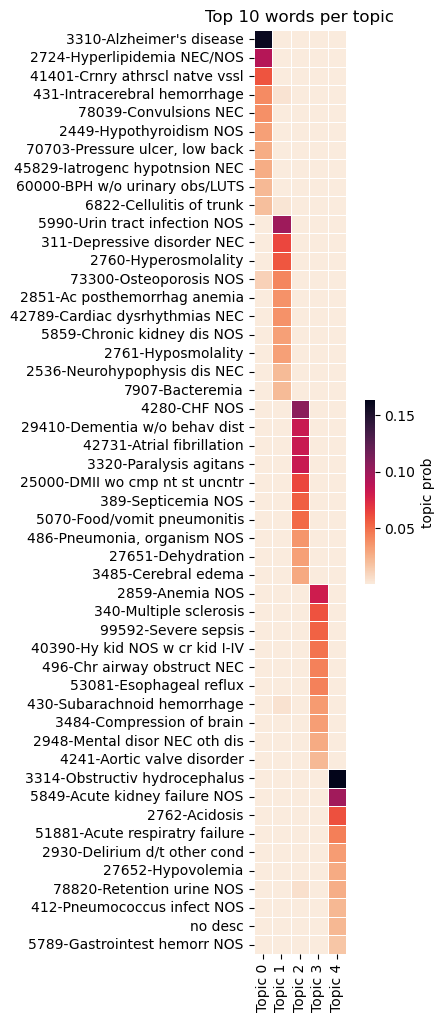

In [398]:
# Plot top words
lda.plot_top_words(phi, lda.r_vocab, codes, n=10)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


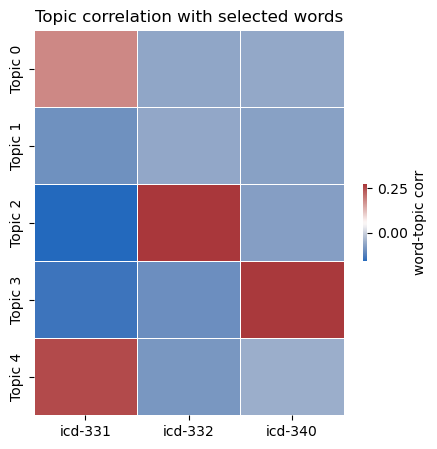

In [399]:
# Plot the correlation between topics and selected words
lda.plot_topic_word_r(theta, docs, words=words)

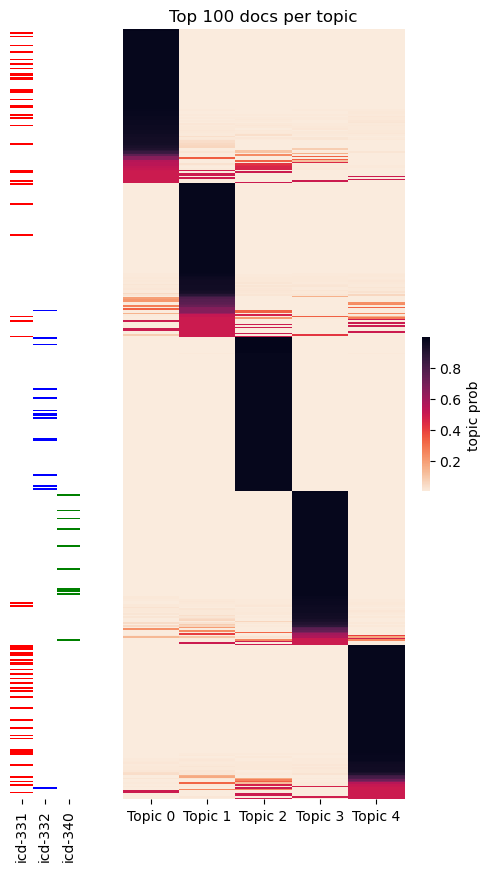

In [400]:
# Plot top documents
lda.plot_top_docs(theta, docs, n=100, words=words)